# Image Segmentation Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/07-object-segmentation-huggingface.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/07-object-segmentation-huggingface.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/07-object-segmentation-huggingface.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>

### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [1]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
!pip install timm
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File ‘00-start-eva-server.ipynb’ already there; not retrieving.

nohup eva_server >> eva.log 2>&1 &
Note: you may need to restart the kernel to use updated packages.


### Download the Videos

In [2]:
# # Getting the video files
!wget -nc "https://www.dropbox.com/s/k00wge9exwkfxz6/ua_detrac.mp4?raw=1" -O ua_detrac.mp4

File ‘ua_detrac.mp4’ already there; not retrieving.


### Load sample video from DAVIS dataset for analysis

In [3]:
cursor.execute('DROP TABLE IF EXISTS VideoForSegmentation;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD VIDEO "ua_detrac.mp4" INTO VideoForSegmentation')
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
 Empty DataFrame
Columns: []
Index: []
@query_time: 0.006894042000006095
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded VIDEO: 1
@query_time: 0.07092833300000478


### Visualize Video

In [4]:
from IPython.display import Video
Video("ua_detrac.mp4", embed=True)

### Register Hugging Face Segmentation Model as an User-Defined Function (UDF) in EVA 

In [5]:
### Using HuggingFace with EVA requires specifying the task
### The task here is 'image-segmentation'
### The model is 'facebook/detr-resnet-50-panoptic'
cursor.execute("""CREATE UDF IF NOT EXISTS HFSegmentation
      TYPE HuggingFace
      'task' 'image-segmentation'
      'model' 'facebook/detr-resnet-50-panoptic'
      """)
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                                         0
0  UDF HFSegmentation successfully added to the database.
@query_time: 2.747014208000003


### Run Image Segmentation on the video

In [6]:
cursor.execute("""SELECT HFSegmentation(data)
                  FROM VideoForSegmentation 
                  WHERE id < 20""")
response = cursor.fetch_all()
response.as_df()

hfsegmentation.score   
0   [0.941237, 0.989336, 0.975436, 0.908714, 0.932...  \
1   [0.988581, 0.962547, 0.92609, 0.930225, 0.9015...   
2   [0.987822, 0.964316, 0.97917, 0.961233, 0.9433...   
3   [0.987373, 0.969857, 0.961493, 0.978733, 0.929...   
4   [0.985898, 0.967353, 0.954409, 0.982553, 0.935...   
5   [0.985015, 0.967054, 0.963676, 0.931484, 0.932...   
6   [0.986503, 0.921225, 0.96359, 0.970691, 0.9810...   
7   [0.987115, 0.956259, 0.969338, 0.972836, 0.912...   
8   [0.990674, 0.939345, 0.968448, 0.965801, 0.990...   
9   [0.989096, 0.965421, 0.951346, 0.984835, 0.923...   
10  [0.989837, 0.966608, 0.962222, 0.928511, 0.934...   
11  [0.988116, 0.965434, 0.967449, 0.976497, 0.986...   
12  [0.986538, 0.96733, 0.959013, 0.980805, 0.9865...   
13  [0.988676, 0.963416, 0.952774, 0.989682, 0.953...   
14  [0.93527, 0.969191, 0.962557, 0.949941, 0.9827...   
15  [0.965414, 0.921933, 0.958416, 0.938287, 0.986...   
16  [0.904745, 0.939118, 0.946338, 0.989233, 0.981...   
17  [0.993987, 0.94204, 0.937986, 0.900621, 0.9522...   
18  [0.983656, 0.945137, 0.959815, 0.918346, 0.981...   
19  [0.903629, 0.937768, 0.949222, 0.978728, 0.978...   

                                 hfsegmentation.label   
0   [motorcycle, motorcycle, person, car, person, ...  \
1   [motorcycle, person, person, car, person, car,...   
2   [motorcycle, person, car, car, person, bridge,...   
3   [motorcycle, person, car, car, person, bridge,...   
4   [motorcycle, person, car, car, person, bridge,...   
5   [motorcycle, person, car, person, bridge, brid...   
6   [motorcycle, person, person, car, car, person,...   
7   [motorcycle, truck, person, car, person, bridg...   
8   [motorcycle, truck, person, car, car, car, per...   
9   [motorcycle, person, car, car, car, person, br...   
10  [motorcycle, person, car, car, car, car, perso...   
11  [motorcycle, person, car, car, car, car, bridg...   
12  [motorcycle, person, car, car, car, car, bridg...   
13  [motorcycle, person, car, car, car, car, bridg...   
14  [motorcycle, truck, person, car, car, car, car...   
15  [motorcycle, truck, person, car, car, car, car...   
16  [truck, person, car, car, car, car, car, motor...   
17  [motorcycle, motorcycle, person, motorcycle, c...   
18  [motorcycle, person, car, car, car, car, car, ...   
19  [person, person, car, car, car, car, car, car,...   

                                  hfsegmentation.mask  
0   [<PIL.Image.Image image mode=L size=960x540 at...  
1   [<PIL.Image.Image image mode=L size=960x540 at...  
2   [<PIL.Image.Image image mode=L size=960x540 at...  
3   [<PIL.Image.Image image mode=L size=960x540 at...  
4   [<PIL.Image.Image image mode=L size=960x540 at...  
5   [<PIL.Image.Image image mode=L size=960x540 at...  
6   [<PIL.Image.Image image mode=L size=960x540 at...  
7   [<PIL.Image.Image image mode=L size=960x540 at...  
8   [<PIL.Image.Image image mode=L size=960x540 at...  
9   [<PIL.Image.Image image mode=L size=960x540 at...  
10  [<PIL.Image.Image image mode=L size=960x540 at...  
11  [<PIL.Image.Image image mode=L size=960x540 at...  
12  [<PIL.Image.Image image mode=L size=960x540 at...  
13  [<PIL.Image.Image image mode=L size=960x540 at...  
14  [<PIL.Image.Image image mode=L size=960x540 at...  
15  [<PIL.Image.Image image mode=L size=960x540 at...  
16  [<PIL.Image.Image image mode=L size=960x540 at...  
17  [<PIL.Image.Image image mode=L size=960x540 at...  
18  [<PIL.Image.Image image mode=L size=960x540 at...  
19  [<PIL.Image.Image image mode=L size=960x540 at...

### Visualizing output of the Image Segmenter on the video

In [7]:
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import cv2

def get_color_mapping(all_labels):
    unique_labels = set(label for labels in all_labels for label in labels)
    num_colors = len(unique_labels)
    colormap = plt.colormaps["tab20"]
    colors = [colormap(i % 20)[:3] for i in range(num_colors)]
    colors = [tuple(int(c * 255) for c in color) for color in colors]
    color_mapping = {label: color for label, color in zip(unique_labels, colors)}
    return  color_mapping

def annotate_single_frame(frame, segments, labels, color_mapping):
    overlay = np.zeros_like(frame)

    # Overlay segments
    for mask, label in zip(segments, labels):
        mask_np = np.array(mask).astype(bool)
        overlay[mask_np] = color_mapping[label]

    # Combine original frame with overlay
    new_frame = Image.blend(
        Image.fromarray(frame.astype(np.uint8)),
        Image.fromarray(overlay.astype(np.uint8)),
        alpha=0.5,
    )

    return new_frame

def annotate_video(segmentations, input_video_path, output_video_path, model_name = 'hfsegmentation'):
    all_segments = segmentations[f'{model_name}.mask']
    all_labels = segmentations[f'{model_name}.label']


    color_mapping = get_color_mapping(all_labels)

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    ret, frame = vcap.read() 
    while ret and frame_id < len(all_segments):
        segments = all_segments[frame_id]
        labels = all_labels[frame_id]
        new_frame = annotate_single_frame(frame, segments, labels, color_mapping)
        video.write(np.array(new_frame))
        if frame_id % 5 == 0:
            legend_patches = [mpatches.Patch(color=np.array(color_mapping[label])/255, label=label) for label in set(labels)]
            plt.imshow(new_frame)
            plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            plt.axis('off')
            plt.tight_layout()
            plt.show()


        frame_id += 1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

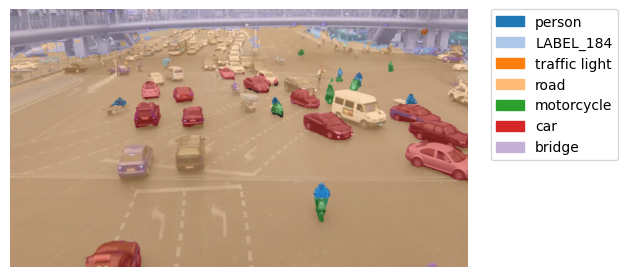

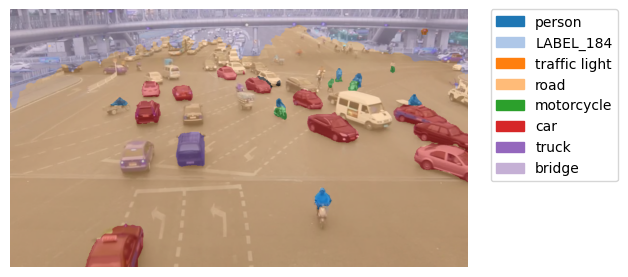

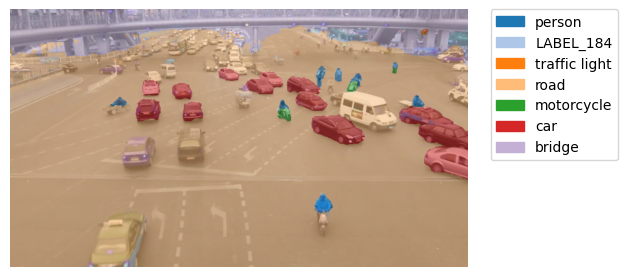

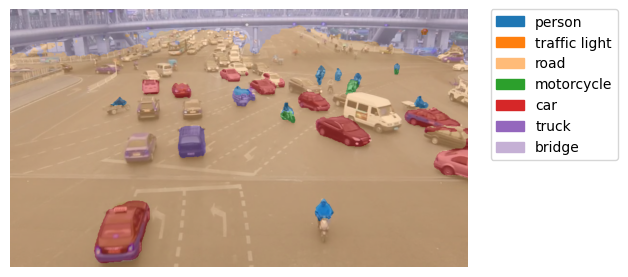

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\x05\x9c\xfb...')

In [9]:
from ipywidgets import Video
input_path = 'ua_detrac.mp4'
output_path = 'video.mp4'

dataframe = response.as_df()
annotate_video(dataframe, input_path, output_path)
Video.from_file(output_path)

### Dropping an User-Defined Function (UDF)

In [10]:
cursor.execute("DROP UDF HFSegmentation;")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                          0
0  UDF HFSegmentation successfully dropped
@query_time: 0.01360779199998774
